# Spam classificator

# Problem definition

We need to classify either if an email is SPAM or not.
This is a BINARY CLASSIFICATION problem, where the label will be spam and get binary values 0/1.

## Precission vs Recall tradeoff

We also want to study the tradeoff between PRECISION and RECALL.

**Precision**: rate of correct classifications. If from 100 mails we classify 70 as spam and 50 are spam, the precision is 50/70. It is, from all the classifications we made, how many of them are correct.

**Recall**: rate of detected spams. If from 100 mails there are 80 spams, and we classify correctly 70, the recall is 70/80. It is how many of the mails that are true spams are correctly classified.

*Precision* = TP / TP+FP

*Recall* = TP / TP+FN

So for a spam filter, we want to maximize the recall.

# Data gathering

### Downloading

In [20]:
import os
import tarfile
import urllib.request
import numpy as np


DOWNLOAD_PATH = "datasets"

SPAM_URL = 'https://spamassassin.apache.org/old/publiccorpus/20021010_spam.tar.bz2'
SPAM_2_URL = 'https://spamassassin.apache.org/old/publiccorpus/20050311_spam_2.tar.bz2'
HAM_URL = 'https://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2'

def fetch_spam_data(spam_url=SPAM_URL, spam2_url=SPAM_2_URL, ham_url=HAM_URL, download_path=DOWNLOAD_PATH):
    if not os.path.isdir(download_path):
        os.makedirs(download_path)
    for url in (spam_url, spam2_url, ham_url):
        filename = url.split('/')[-1]
        path = os.path.join(download_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        with tarfile.open(path) as tar:
            tar.extractall(path=download_path)

fetch_spam_data()

### Loading data

In [21]:
from os import listdir
import pandas as pd

SPAM_FOLDER = os.path.join(DOWNLOAD_PATH, 'spam')
SPAM2_FOLDER = os.path.join(DOWNLOAD_PATH, 'spam_2')
HAM_FOLDER = os.path.join(DOWNLOAD_PATH, 'easy_ham')

exclude = ['0000.7b1b73cf36cf9dbc3d64e3f2ee2b91f1']

def load_spam_data(spam_folder=SPAM_FOLDER,  spam2_folder=SPAM2_FOLDER, ham_folder=HAM_FOLDER):
    data = []
    for filename in listdir(spam_folder):
        if filename in exclude:
            continue
        with open(os.path.join(spam_folder, filename), 'rb') as f:
            text = f.read().decode('latin-1')
            data.append((text, 1))
    for filename in listdir(spam2_folder):
        with open(os.path.join(spam2_folder, filename), 'rb') as f:
            text = f.read().decode('latin-1')
            data.append((text, 1))
    for filename in listdir(ham_folder):
        with open(os.path.join(ham_folder, filename), 'rb') as f:
            text = f.read().decode('latin-1')
            data.append((text, 0))       

    spam_df = pd.DataFrame(data, columns=['text', 'spam'])
    return spam_df

spam_df = load_spam_data()
# save in csv
spam_df.to_csv(os.path.join(DOWNLOAD_PATH, 'spam.csv'), index=False)

In [22]:
spam_df.head()

,text,spam
0,From 12a1mailbot1@web.de Thu Aug 22 13:17:22 ...,1
1,From ilug-admin@linux.ie Thu Aug 22 13:27:39 ...,1
2,From sabrina@mx3.1premio.com Thu Aug 22 14:44...,1
3,From wsup@playful.com Thu Aug 22 16:17:00 200...,1
4,From social-admin@linux.ie Thu Aug 22 16:37:3...,1


In [23]:
print(spam_df['spam'].value_counts())

spam
0    2551
1    1897
Name: count, dtype: int64


# Data preparation

## Train test split

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(spam_df, spam_df['spam']):
    strat_train_set = spam_df.iloc[train_index]
    strat_test_set = spam_df.iloc[test_index]

print(f"Training set size: {len(strat_train_set)}")
print(f"Test set size: {len(strat_test_set)}")
print(f"Training set spam ratio: {strat_train_set['spam'].value_counts() / len(strat_train_set)}")
print(f"Test set spam ratio: {strat_test_set['spam'].value_counts() / len(strat_test_set)}")

Training set size: 3558
Test set size: 890
Training set spam ratio: spam
0    0.573637
1    0.426363
Name: count, dtype: float64
Test set spam ratio: spam
0    0.573034
1    0.426966
Name: count, dtype: float64


## Feature engineering

I am going to create two types of new features:
- stats about the email: proportion of upper/lower chars, num of exclamations, question marks, etc
- vector of processed words

### Mail stats

In [80]:
# Function to calc stats from sender
import re
def sender_stats(text):
    sender = re.findall(r'From: (.*)', text)
    if len(sender) == 0:
        return np.array([0, 0, 0])
    sender = sender[0]
    if sender == '':
        return np.array([0, 0, 0])
    sender_num_rate = len([c for c in sender if c.isdigit()]) / len(sender)
    sender_upper_rate = len([c for c in sender if c.isupper()]) / len(sender)
    sender_exclamation_rate = len([c for c in sender if c == '!']) / len(sender)

    return np.array([sender_num_rate, sender_upper_rate, sender_exclamation_rate])

# Function to calc stats from subject

CURRENCY_SYMBOLS = ['$', '£', '€', '¥', '₹', '₽', '₩', '₴', '₱', '₲', '₪', '₫', '₵', '₭', '₦', '₸', '₼', '₡', '₢', '₯', '₠', '₧', '₣', '₤', '₶', '₸', '₺', '₼', '₽', '₾', '₿']

def subject_stats(text):
    subject = re.findall(r'Subject: (.*)', text)
    if len(subject) == 0:
        return np.array([0, 0, 0, 0])
    subject = subject[0]
    if subject == '':
        return np.array([0, 0, 0, 0])
    subject_num_rate = len([c for c in subject if c.isdigit()]) / len(subject)
    subject_upper_rate = len([c for c in subject if c.isupper()]) / len(subject)
    subject_currency_rate = len([c for c in subject if c in CURRENCY_SYMBOLS]) / len(subject)
    subject_exclamation_rate = len([c for c in subject if c == '!']) / len(subject)
    
    return np.array([subject_num_rate, subject_upper_rate, subject_currency_rate, subject_exclamation_rate])

In [26]:
# Create a custom Transformer that will be called from a ColumnTransformer
# This custom transformer will ingest a Pandas Df of dimmension (n, 1) and return a numpy array of dimmension (n, x), x = number of new features

from sklearn.base import BaseEstimator, TransformerMixin
class AttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # X is a Pandas Df of dimmension (n, 1)
        # Each new feature is a np array of dimmension (n, 1)

        # If len in words is 0, return np array of zeros
        avg_word_len = X['text'].apply(lambda x: np.divide(len(x), len(x.split()), out=np.zeros_like(float(len(x))), where=len(x.split())!=0)).values.reshape(-1, 1)
        rate_upper = X['text'].apply(lambda x: np.divide(len([c for c in x if c.isupper()]), len(x), out=np.zeros_like(float(len(x))), where=len(x)!=0)).values.reshape(-1, 1)
        rate_exclamation = X['text'].apply(lambda x: np.divide(len([c for c in x if c == '!']), len(x), out=np.zeros_like(float(len(x))), where=len(x)!=0)).values.reshape(-1, 1)
        rate_question = X['text'].apply(lambda x: np.divide(len([c for c in x if c == '?']), len(x), out=np.zeros_like(float(len(x))), where=len(x)!=0)).values.reshape(-1, 1)
        sender_num_rate, sender_upper_rate, sender_exclamation_rate = np.array(list(X['text'].apply(sender_stats))).T
        subject_num_rate, subject_upper_rate, subject_currency_rate, subject_exclamation_rate = np.array(list(X['text'].apply(subject_stats))).T


        return np.c_[
            avg_word_len, rate_upper, rate_exclamation, rate_question, 
            sender_num_rate, sender_upper_rate, sender_exclamation_rate,
            subject_num_rate, subject_upper_rate, subject_currency_rate, subject_exclamation_rate
        ]

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

stats_preprocessing_pipeline = Pipeline([
    ('add_stats', AttributesAdder()),
    ('std_scaler', StandardScaler())
])

# Create column transformer that will apply the stats_preprocessing_pipeline to the text column
stats_column_transformer = ColumnTransformer([
    ('stats', stats_preprocessing_pipeline, ['text'])
], remainder='passthrough')

In [28]:
# Test on sample data
sample = strat_train_set.sample(5)
print(sample)

sample_pr = stats_column_transformer.fit_transform(sample)
print(sample_pr)

                                                   text  spam
149   From lu5guxf4c4149@yahoo.com  Wed Aug 28 15:39...     1
578   From 3cKq2amCZ@hotmail.com  Sat Jul  7 02:01:4...     1
2491  From fork-admin@xent.com  Tue Sep 10 11:07:34 ...     0
3085  From rpm-list-admin@freshrpms.net  Tue Sep 10 ...     0
948   From malalad@mail.ru  Mon Jun 24 17:06:29 2002...     1
[[ 0.63982221 -1.35847552  0.18919172 -1.16941675  1.72735711 -1.03842471
   0.         -0.5        -0.35689306  0.         -0.5         1.        ]
 [-1.55690071  1.76074799  1.83077954  0.75570758  0.5442358   1.85861117
   0.         -0.5        -1.03442844  0.          2.          1.        ]
 [-0.81336918 -0.14927985 -0.95702528  1.26097277 -0.75719764 -0.04328904
   0.         -0.5         0.25583459  0.         -0.5         0.        ]
 [ 0.92804784 -0.1299362  -0.27493031  0.32215316 -0.75719764 -0.67443815
   0.         -0.5        -0.67573324  0.         -0.5         0.        ]
 [ 0.80239984 -0.12305643 -0.788

#### Word Vectorizer

In [29]:
import re
from nltk.stem import PorterStemmer

def spamEmailPreprocessor(
    email_text,
    stop_words_set,
    remove_html_header=True,
    remove_punctuation=True,
    stem=True
):
    currency_symbols = ['$', '£', '€', '¥', '₹', '₽', '₩', '₴', '₱', '₲', '₪', '₫', '₵', '₭', '₦', '₸', '₼', '₡', '₢', '₯', '₠', '₧', '₣', '₤', '₶', '₸', '₺', '₼', '₽', '₾', '₿']
    punctuation_symbols = ['!', '"', '#', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', 
                   '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']

    if remove_html_header:
        # HTML header is separated from the rest of the email by at least one blank line
        split_email = email_text.split('\n\n', 1)
        email_text = split_email[1] if len(split_email) > 1 else split_email[0]

    email_text = email_text.lower()
    email_text = ' '.join([word.lower() for word in email_text.split() if word.lower() not in stop_words_set])

    if remove_punctuation:
        for symbol in punctuation_symbols:
            email_text = email_text.replace(symbol, ' ')

    if stem:
        stemmer = PorterStemmer()
        email_text = ' '.join([stemmer.stem(word) for word in email_text.split()])

    # Replace numbers with NUMBER xx or xx.xx
    email_text = re.sub(r'\d+\.\d+', ' NUMBER ', email_text)
    email_text = re.sub(r'\d+', ' NUMBER ', email_text)

    # Replace currency symbols with CURRENCY
    for symbol in currency_symbols:
        email_text = email_text.replace(symbol, ' CURRENCY ')

    # Replace email addresses with EMAIL
    email_text = re.sub(r'\S+@\S+', ' EMAIL ', email_text)

    # Replace URLs with URL
    email_text = re.sub(r'http\S+', ' URL ', email_text)

    # Replace IP addresses with IP
    email_text = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' IP ', email_text)
    
    return email_text

In [30]:
from nltk.corpus import stopwords
stop_words_en = set(stopwords.words('english'))

In [31]:
# Test on rand email
rand_email = strat_train_set.sample(1, random_state=41)['text'].values[0]
# Preprocess
rand_email_pr = spamEmailPreprocessor(rand_email, stop_words_en)
print(rand_email_pr)

got bad credit fix it ye fix credit report easi use softwar attorney fee simpli download way good credit get rid neg credit report easili nucredit avail two version nucredit individu use  CURRENCY  NUMBER   NUMBER  credit pro use  NUMBER  peopl  CURRENCY  NUMBER   NUMBER  follow link start repair credit today http  NUMBER   NUMBER   NUMBER   NUMBER  inbox NUMBER  wish remov mail list pleas click link indic address receiv origin email properli remov list mailto nucredit NUMBER  yahoo com subject remov


In [32]:
# Create a custom Transformer, which Transform will apply the spamEmailPreprocessor function to the text column

stop_words_set = set(stopwords.words('english'))

class EmailPreprocessorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, remove_html_header=True, remove_punctuation=True, stem=True):
        self.stop_words_set = stop_words_set
        self.remove_html_header = remove_html_header
        self.remove_punctuation = remove_punctuation
        self.stem = stem

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_pr = X['text'].apply(
            lambda x: spamEmailPreprocessor(
                x, 
                self.stop_words_set, 
                self.remove_html_header, 
                self.remove_punctuation, 
                self.stem
            )
        ).values.reshape(-1, 1)

        return X_pr

In [33]:
# Vectorizer custom transformer

from sklearn.feature_extraction.text import CountVectorizer

class VectorizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_features=1000):
        self.max_features = max_features

    def fit(self, X, y=None):
        self.vectorizer = CountVectorizer(max_features=self.max_features)
        self.vectorizer.fit(X.ravel())
        return self

    def transform(self, X, y=None):
        return self.vectorizer.transform(X.ravel())

In [34]:
preprocessor = EmailPreprocessorTransformer()

text_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('vectorizer', VectorizerTransformer())
])

In [62]:
# Final pipeline

from sklearn.pipeline import FeatureUnion

full_pipeline = ColumnTransformer([
    ('stats', stats_preprocessing_pipeline, ['text']),
    ('text', text_pipeline, ['text'])
], remainder='drop')

# Test on sample data
sample = strat_train_set.sample(5)
# print(sample)

sample_pr = full_pipeline.fit_transform(sample)
print(sample_pr.shape)

(5, 699)


# Model training

## Choosing a classifier

In [63]:
# Number of samples
spam_df.shape

(4448, 2)

In [64]:
y_train = strat_train_set['spam']
X_train = strat_train_set.drop('spam', axis=1)
# Print shape and type
print(X_train.shape)
print(type(X_train))

In [82]:
strat_test_set.head()

y_test_pr = full_pipeline.transform(strat_test_set)

X_test = strat_test_set.drop('spam', axis=1)
y_test = strat_test_set['spam']

### Linear SVC

Linear SVC -> Naive Bayes

In [67]:
# SVC Classifier with GridSearchCV

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

pipeline_with_svc = Pipeline([
    ('preprocessing', full_pipeline),
    ('svc', SVC())
])

param_grid = [
    {
        'preprocessing__text__preprocessor__remove_html_header': [True, False], 
        'preprocessing__text__preprocessor__remove_punctuation': [True, False], 
        'preprocessing__text__preprocessor__stem': [True, False], 
        'preprocessing__text__vectorizer__max_features': [1e3, 1e4, 1e5, 1e6], 
        'svc__kernel': ['linear', 'rbf'], 
        'svc__C': [1e-4, 1e-3, 1e-2, 1e-1]
    }
]

svc_clf = SVC()

grid_search = GridSearchCV(pipeline_with_svc, param_grid, cv=3, scoring='accuracy', verbose=10, n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 160 candidates, totalling 480 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('stats',
                                                                         Pipeline(steps=[('add_stats',
                                                                                          AttributesAdder()),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['text']),
                                                                        ('text',
                                                                         Pipeline(steps=[('preprocessor',
                                                                                          EmailPreprocessorTransformer()),
                                                                                         ('vectorizer',
                                                                                          VectorizerTransformer())]),
                                                                         ['text'])])),
                                       ('svc', SVC())]),
             n_jobs=-1,
             para...id=[{'preprocessing__text__preprocessor__remove_html_header': [True,
                                                                                    False],
                          'preprocessing__text__preprocessor__remove_punctuation': [True,
                                                                                    False],
                          'preprocessing__text__preprocessor__stem': [True,
                                                                      False],
                          'preprocessing__text__vectorizer__max_features': [1000,
                                                                            2000],
                          'svc__C': [0.1, 1, 10, 100, 1000],
                          'svc__kernel': ['linear', 'rbf']}],
             scoring='accuracy', verbose=10)

In [68]:
grid_search.best_params_

{'preprocessing__text__preprocessor__remove_html_header': False,
 'preprocessing__text__preprocessor__remove_punctuation': True,
 'preprocessing__text__preprocessor__stem': True,
 'preprocessing__text__vectorizer__max_features': 2000,
 'svc__C': 0.1,
 'svc__kernel': 'linear'}

#### Model evaluation on test

In [72]:
# Test
strat_test_set.head()

,text,spam
2650,From fork-admin@xent.com Sun Sep 22 14:11:39 ...,0
1080,From andramariehuaa@mail.com Mon Jun 24 17:52...,1
2852,From fork-admin@xent.com Sat Oct 5 17:22:20 ...,0
663,From hpr-2@solarisexpert.com Mon Jun 24 17:41...,1
313,From iiu-admin@taint.org Sun Sep 15 12:22:02 ...,1


In [83]:
# Confussion matrix
from sklearn.metrics import confusion_matrix

y_test_pred = grid_search.predict(X_test)

confusion_matrix(y_test, y_test_pred)

array([[509,   1],
       [  4, 376]], dtype=int64)

In [84]:
# Precision and recall

from sklearn.metrics import precision_score, recall_score

print(f"Precision: {precision_score(y_test, y_test_pred)}")
print(f"Recall: {recall_score(y_test, y_test_pred)}")

Precision: 0.9973474801061007
Recall: 0.9894736842105263


We don't need to tune the precision/recall tradeoff just because both precision and recall are very high.

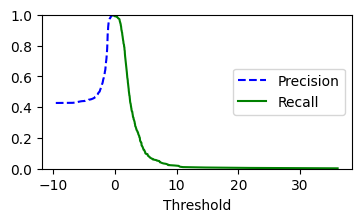

In [90]:
# Precision vs recall curve

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_scores = grid_search.decision_function(X_test)

precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(4, 2))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center right')
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


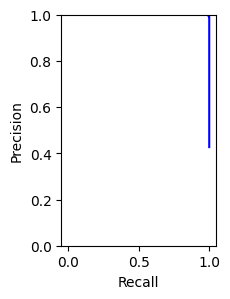

In [88]:
# Precision and recall vs threshold curve

def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize=(2, 3))
    plt.plot(recalls, precisions, 'b-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0, 1])

plot_precision_vs_recall(precisions, recalls)


ROC AUC score: 0.9999690402476781


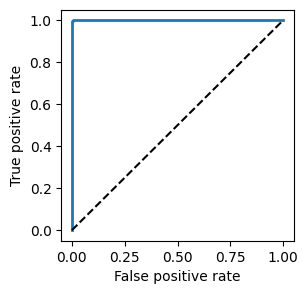

In [93]:
# ROC curve

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(3, 3))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

plot_roc_curve(fpr, tpr)

# ROC AUC score
roc_score = roc_auc_score(y_test, y_scores)
print(f"ROC AUC score: {roc_score}")

In [94]:
# F1 weighted score
from sklearn.metrics import f1_score

f1_score(y_test, y_test_pred, average='weighted')

0.9943791279197489

#### Feature importance